In [1]:
# JSS
## TODO 
#using pca to reduce the dimensionality of the global descriptors
#using MobileVnet instead of netVLAD
#using hfnet instead of netVlAD and MobileVnet --that is not working 
# this will also help reduce the complexity 
#understand what superglue is outputting
# getting two models from SFM 
# Setting up the scale of the model -- this is done easy and simple
import numpy as np
import argparse
import yaml
import logging
from pathlib import Path
from tqdm import tqdm
from pprint import pformat
import h5py
import json
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from shutil import copyfile
# from notebooks.utils import plot_images, plot_matches, add_frame
from hfnet.models import get_model  

In [2]:
# send the path to the image directory and get the path to all the images in it
def image_directory_parser(path, viewer=True, number= 4):    
    globs=['*.jpg', '*.png', '*.jpeg', '*.JPG', '*.PNG']
    ## can also use sufix instead of with method
    image_path = []
    for g in globs:
        image_path += list(path.glob("**/"+g))
    print(len(image_path))
    if viewer:
        nrows = number
        ncols = number
        fig = plt.gcf()
        fig.set_size_inches(ncols*4, ncols*4)
        for i in range(2*number):
            sp = plt.subplot(nrows, ncols, i + 1)
            sp.axis('Off') # Don't show axes (or gridlines)
            img = mpimg.imread((image_path[i]))
            plt.imshow(img)
        plt.show()
    return image_path

1850


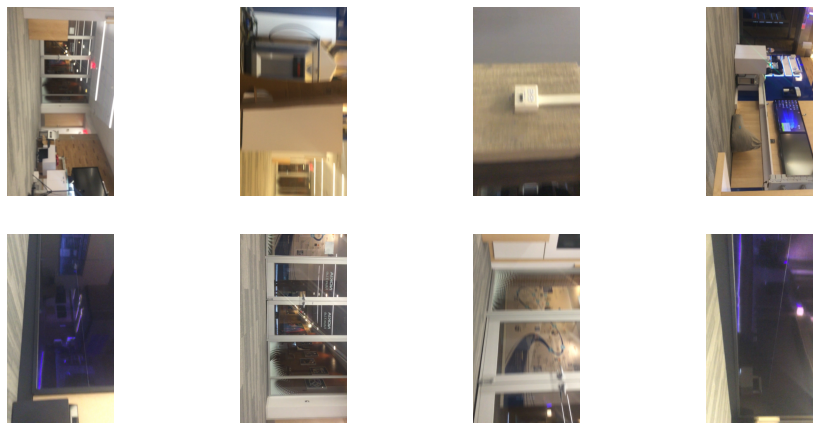

In [5]:
# path_to_images_for_map = Path('/home/Hierarchical-Localization/datasets/Trajectory5/skip5')
# path_to_images_for_map = Path('/home/Hierarchical-Localization/datasets/ipadT4images')
path_to_images_for_map = Path('/home/Hierarchical-Localization/datasets/ipadT3images')
image_path = image_directory_parser(path_to_images_for_map, viewer=True, number = 4) 


In [6]:
def dictionary_of_images(image_path):
    image_dict ={}
    for i,j in tqdm(enumerate(image_path)):
        image_array = cv2.imread(str(j))
#         print(image_path[i].name)
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        image_dict[i] = {"image":image_array, "name": image_path[i].name, "number": i}
    return image_dict

In [7]:
image_dict = dictionary_of_images(image_path)
print(len(image_dict))

1850it [00:21, 84.92it/s] 

1850


In [8]:
# this finds the global matrix and 
def global_dict_matrix_and_H5_map(config, image_dict):
    predictions_dict = {}
    global_feature_path = (config["output"])/"global_features.h5"
    global_feature_file = h5py.File(str(global_feature_path), 'w')
    checkpoint_path = Path(config["checkpoint_path"])
    keys = ['global_descriptor']    
    with get_model(config['model']['name'])(
            data_shape={'image': [None, None, None, 3]},
            **config['model']) as net:
        if checkpoint_path is not None:
            net.load(str(checkpoint_path))
        for i in tqdm(range(len(image_dict))):
            data = image_dict[i] ## selecting using index
            predictions = net.predict(data, keys=keys)
            predictions_dict[i] = {"global_descriptor":predictions['global_descriptor'], "name" : data['name']}   
            if i == 0:
                global_matrix = np.array(predictions['global_descriptor'])
            else:
                global_matrix = np.vstack((global_matrix,predictions['global_descriptor']))
            grp = global_feature_file.create_group(data['name'])
            grp.create_dataset('global_descriptor', data=predictions['global_descriptor'])
        global_feature_file.close()
    return predictions_dict, global_matrix
def compute_distance(desc1, desc2):
    # For normalized descriptors, computing the distance is a simple matrix multiplication.
    return 2 * (1 - desc1 @ desc2.T)
## needs both global matrix and dict as we need to give names too
## I am idiot if I keep wiritng codes like this one lol ;)
# Need to change it hehehe
# Writing the .txt file.
def text_file_for_global_matches(global_feature_dict, global_feature_matrix, path, number): 
    predictions_dict_matches = {}
    for i in tqdm(range(len(global_feature_dict))):
        current_descriptor = global_feature_matrix[i, :]
        neighbours = compute_distance(current_descriptor, global_feature_matrix)
        predictions_dict_matches[i] = ((np.argsort(neighbours))[:number])[1 :]
    #first writing the file
    output_file_txt = path/"global_feature.txt"
    with open(output_file_txt, 'w') as f:
        for i in tqdm(range(len(predictions_dict_matches))):
            current_image_name = global_feature_dict[i]["name"]
            current_image_matches = predictions_dict_matches[i]
            string_list = []
            for j in range(len(current_image_matches)):
                    if i == 0 and j ==0:
                        making_a_string = current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    
                    else: 
                        making_a_string = "\n" + current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    f.write(making_a_string)  
    ## checking common lines and rewriting
    image_list_for_finding_common_separated = []
    with open(output_file_txt, 'r') as f:
        image_list_for_finding_common = [l.strip() for l in f]
    for i in range(len(image_list_for_finding_common)):
        current_index_value = image_list_for_finding_common[i]
        current_index_value = list(current_index_value.split(" "))
        image_list_for_finding_common_separated.append(sorted(current_index_value))
    ilf = sorted(image_list_for_finding_common_separated)
    final_list = []
    for i in range(len(ilf)):
        if ilf[i] in final_list:
            pass
        else:
            final_list.append(ilf[i])
    with open(output_file_txt, 'w') as f:
        for i in range(len(final_list)):
            if i == 0:
                making_a_string = final_list[i][0]+ " " + final_list[i][1]
            else:
                making_a_string = "\n" + final_list[i][0]+ " " + final_list[i][1]
            f.write(making_a_string)

In [9]:
output_path = Path("/home/Hierarchical-Localization/outputs/sfm_T3_Domain_Lab")
output_path.mkdir()
checkpoint_path = Path("/home/Hierarchical-Localization/weights/vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white")

In [10]:
config_global = {'output':output_path, 'checkpoint_path':checkpoint_path, 'data': {'name': 'aachen', 'load_db': False, 'load_queries': True, 'resize_max': 960}, 'model': {'name': 'netvlad_original', 'local_descriptor_layer': 'conv3_3', 'image_channels': 1}, 'weights': 'vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white'}         
global_dict_map, global_matrix = global_dict_matrix_and_H5_map(config_global, image_dict)

W0226 02:15:12.639455 139776884008768 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:104: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0226 02:15:12.660445 139776884008768 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:124: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0226 02:15:12.661615 139776884008768 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:124: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0226 02:15:12.662720 139776884008768 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:275: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0226 02:15:12.665954 139776884008768 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/h

In [12]:
text_file_for_global_matches(global_dict_map, global_matrix,output_path,50)

100%|██████████| 1850/1850 [00:00<00:00, 14061.00it/s]


In [13]:
### Bringing in HLOC
%load_ext autoreload
%autoreload 2
from hloc import extract_features, match_features, reconstruction, visualization

In [14]:
feature_conf_superpoint = {'output': 'features_superpoint', 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 960}}
extract_features.main(feature_conf_superpoint,path_to_images_for_map,output_path)

I0226 02:20:42.551376 139776884008768 extract_features.py:123] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'features_superpoint',
 'preprocessing': {'grayscale': True, 'resize_max': 960}}


Loaded SuperPoint model


I0226 02:20:46.116100 139776884008768 extract_features.py:81] Found 1850 images in root /home/Hierarchical-Localization/datasets/ipadT3images.
100%|██████████| 1850/1850 [00:20<00:00, 90.56it/s] 
I0226 02:21:06.570440 139776884008768 extract_features.py:160] Finished exporting features.


In [15]:
matcher_conf = {'output': 'matches-superglue', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}
features = feature_conf_superpoint['output']
sfm_pairs = output_path/"global_feature.txt"
match_features.main(matcher_conf, sfm_pairs, features, output_path)

I0226 02:21:30.110685 139776884008768 match_features.py:42] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
  0%|          | 2/55435 [00:00<51:23, 17.98it/s]

Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 55435/55435 [50:45<00:00, 18.20it/s]
I0226 03:12:15.713698 139776884008768 match_features.py:114] Finished exporting matches.


In [19]:
sfm_dir = output_path/'sfm_superpoint+superglue'
feature_file = output_path/'features_superpoint.h5'
match_file = output_path/'features_superpoint_matches-superglue_global_feature.h5'

In [34]:
import argparse
import logging
from pathlib import Path
import shutil
import multiprocessing
import subprocess
import pprint

from hloc.utils.read_write_model import read_cameras_binary
from hloc.utils.database import COLMAPDatabase
from hloc.triangulation import (
    import_features, import_matches, geometric_verification)


def create_empty_db(database_path):
    logging.info('Creating an empty database...')
    db = COLMAPDatabase.connect(database_path)
    db.create_tables()
    db.commit()
    db.close()


def import_images(colmap_path, sfm_dir, image_dir, database_path,
                  single_camera=False):
    logging.info('Importing images into the database...')
    images = list(image_dir.iterdir())
    if len(images) == 0:
        raise IOError(f'No images found in {image_dir}.')

    # We need to create dummy features for COLMAP to import images with EXIF
    dummy_dir = sfm_dir / 'dummy_features'
    dummy_dir.mkdir()
    for i in images:
        with open(str(dummy_dir / (i.name + '.txt')), 'w') as f:
            f.write('0 128')

    cmd = [
        str(colmap_path), 'feature_importer',
        '--database_path', str(database_path),
        '--image_path', str(image_dir),
        '--import_path', str(dummy_dir),
        '--ImageReader.single_camera',
        str(int(single_camera))]
    ret = subprocess.call(cmd)
    if ret != 0:
        logging.warning('Problem with feature_importer, exiting.')
        exit(ret)

    db = COLMAPDatabase.connect(database_path)
    db.execute("DELETE FROM keypoints;")
    db.execute("DELETE FROM descriptors;")
    db.commit()
    db.close()
    shutil.rmtree(str(dummy_dir))


def get_image_ids(database_path):
    db = COLMAPDatabase.connect(database_path)
    images = {}
    for name, image_id in db.execute("SELECT name, image_id FROM images;"):
        images[name] = image_id
    db.close()
    return images


# def run_reconstruction(colmap_path, model_path, database_path, image_dir,
#                        min_num_matches=None):
#     logging.info('Running the 3D reconstruction...')
#     model_path.mkdir(exist_ok=True)

#     cmd = [
#         str(colmap_path), 'mapper',
#         '--database_path', str(database_path),
#         '--image_path', str(image_dir),
#         '--output_path', str(model_path)]
# #     ,
# #         '--Mapper.num_threads', str(min(multiprocessing.cpu_count(), 16))]
#     if min_num_matches:
#         cmd += ['--Mapper.min_num_matches', str(min_num_matches)]
#     logging.info(' '.join(cmd))
#     ret = subprocess.call(cmd)
#     if ret != 0:
#         logging.warning('Problem with mapper, exiting.')
#         exit(ret)

#     models = list(model_path.iterdir())
#     if len(models) == 0:
#         logging.error('Could not reconstruct any model!')
#         return False
#     logging.info(f'Reconstructed {len(models)} models.')

#     largest_model = None
#     largest_model_num_images = 0
#     for model in models:
#         num_images = len(read_cameras_binary(str(model / 'cameras.bin')))
#         if num_images > largest_model_num_images:
#             largest_model = model
#             largest_model_num_images = num_images
#     assert largest_model_num_images > 0
#     logging.info(f'Largest model is #{largest_model.name} '
#                  'with {largest_model_num_images} images.')

#     stats_raw = subprocess.check_output(
#         [str(colmap_path), 'model_analyzer',
#          '--path', str(largest_model)])
#     stats_raw = stats_raw.decode().split("\n")
#     stats = dict()
#     for stat in stats_raw:
#         if stat.startswith("Registered images"):
#             stats['num_reg_images'] = int(stat.split()[-1])
#         elif stat.startswith("Points"):
#             stats['num_sparse_points'] = int(stat.split()[-1])
#         elif stat.startswith("Observations"):
#             stats['num_observations'] = int(stat.split()[-1])
#         elif stat.startswith("Mean track length"):
#             stats['mean_track_length'] = float(stat.split()[-1])
#         elif stat.startswith("Mean observations per image"):
#             stats['num_observations_per_image'] = float(stat.split()[-1])
#         elif stat.startswith("Mean reprojection error"):
#             stats['mean_reproj_error'] = float(stat.split()[-1][:-2])

#     return stats


def main(sfm_dir, image_dir, pairs, features, matches,
         colmap_path='colmap', single_camera=False,
         skip_geometric_verification=False,
         min_match_score=None, min_num_matches=None):

    assert features.exists(), features
    assert pairs.exists(), pairs
    assert matches.exists(), matches

    sfm_dir.mkdir(parents=True, exist_ok=True)
    database = sfm_dir / 'database.db'
    models = sfm_dir / 'models'
    models.mkdir(exist_ok=True)

    create_empty_db(database)
    import_images(
        colmap_path, sfm_dir, image_dir, database, single_camera)
    image_ids = get_image_ids(database)
    import_features(image_ids, database, features)
    import_matches(image_ids, database, pairs, matches,
                   min_match_score, skip_geometric_verification)
    if not skip_geometric_verification:
        geometric_verification(colmap_path, database, pairs)
#     stats = run_reconstruction(
#         colmap_path, models, database, image_dir, min_num_matches)
#     stats['num_input_images'] = len(image_ids)
#     logging.info(f'Statistics:\n{pprint.pformat(stats)}')

In [35]:
main(
    sfm_dir,
    path_to_images_for_map,
    sfm_pairs,
    feature_file,
    match_file)

I0226 03:29:27.934522 139776884008768 <ipython-input-34-9e9e232fc48e>:16] Creating an empty database...
I0226 03:29:27.964030 139776884008768 <ipython-input-34-9e9e232fc48e>:25] Importing images into the database...
I0226 03:29:43.721862 139776884008768 triangulation.py:41] Importing features into the database...
100%|██████████| 1850/1850 [00:00<00:00, 1991.21it/s]
I0226 03:29:44.705651 139776884008768 triangulation.py:59] Importing matches into the database...
100%|██████████| 55435/55435 [00:27<00:00, 2035.37it/s]
I0226 03:30:12.293114 139776884008768 triangulation.py:100] Performing geometric verification of the matches...


In [36]:
import subprocess
cmd = ["colmap", "mapper",
      '--project_path', str(sfm_dir/'models'/'project.ini')]


In [37]:
subprocess.call(cmd)

0

In [38]:
path_to_query = Path("/home/Hierarchical-Localization/datasets/testing")

In [40]:
image_path_query = image_directory_parser(path_to_query, viewer =False)

4


In [41]:
image_dict_query = dictionary_of_images(image_path_query)

4it [00:00, 81.28it/s]


In [47]:
def global_dict_matrix_query(config, image_dict):
    predictions_dict = {}
    checkpoint_path = Path(config["checkpoint_path"])
    keys = ['global_descriptor']    
    with get_model(config['model']['name'])(
            data_shape={'image': [None, None, None, 3]},
            **config['model']) as net:
        if checkpoint_path is not None:
            net.load(str(checkpoint_path))
        for i in tqdm(range(len(image_dict))):
            data = image_dict[i] ## selecting using index
            predictions = net.predict(data, keys=keys)
            predictions_dict[i] = {"global_descriptor":predictions['global_descriptor'], "name" : data['name']}   
            if i == 0:
                global_matrix = np.array(predictions['global_descriptor'])
            else:
                global_matrix = np.vstack((global_matrix,predictions['global_descriptor']))
    return predictions_dict, global_matrix

In [48]:
predicitons_dict_query, global_matric_query = global_dict_matrix_query(config_global, image_dict_query)

I0226 04:50:58.571404 139776884008768 saver.py:1280] Restoring parameters from /home/Hierarchical-Localization/weights/vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white
100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


In [49]:
def query_global_txt_file_creator(image_dict_query, image_dict_map, global_matrix, predictions_dict_query, path, file_name, number):
    with open(path/file_name, 'w') as f:
        for i in tqdm(range(len(predictions_dict_query))):
            current_descriptor = predictions_dict_query[i]["global_descriptor"]
            neighbours = compute_distance(current_descriptor, global_matrix)
            global_matches = ((np.argsort(neighbours))[:number])
            for j in range(len(global_matches)):
                if i == 0 and j ==0:
                    string = image_dict_query[i]["name"]+ " "+ image_dict_map[global_matches[j]]["name"]
                else:
                    string = "\n"+ image_dict_query[i]["name"]+ " "+ image_dict_map[global_matches[j]]["name"]
                f.write(string) 

In [50]:
query_global_txt_file_creator(image_dict_query, image_dict, global_matrix, predicitons_dict_query, output_path,'global_query.txt' , 10)

100%|██████████| 4/4 [00:00<00:00, 234.36it/s]


In [43]:
feature_conf_superpoint_query = {'output': 'features_superpoint_query', 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 960}}


In [42]:
extract_features.main(feature_conf_superpoint,path_to_query,output_path)

I0226 04:41:13.793082 139776884008768 extract_features.py:123] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'features_superpoint_query',
 'preprocessing': {'grayscale': True, 'resize_max': 960}}
I0226 04:41:13.840865 139776884008768 extract_features.py:81] Found 4 images in root /home/Hierarchical-Localization/datasets/testing.
  0%|          | 0/4 [00:00<?, ?it/s]

Loaded SuperPoint model


100%|██████████| 4/4 [00:00<00:00,  8.29it/s]
I0226 04:41:14.330464 139776884008768 extract_features.py:160] Finished exporting features.


In [44]:
matcher_conf_query = {'output': 'choosen_matches', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}
features_query = feature_conf_superpoint_query['output']
loc_pairs = output_path/"global_query.txt"

In [45]:
from hloc import feature_matcher_map_query

In [51]:
feature_matcher_map_query.main(matcher_conf_query, loc_pairs, features, output_path, features_query)

I0226 04:53:04.455108 139776884008768 feature_matcher_map_query.py:42] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'choosen_matches'}
I0226 04:53:04.457393 139776884008768 feature_matcher_map_query.py:50] Using query_features features_superpoint_query
  5%|▌         | 2/40 [00:00<00:02, 18.47it/s]

Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 40/40 [00:02<00:00, 18.25it/s]
I0226 04:53:06.956701 139776884008768 feature_matcher_map_query.py:127] Finished exporting matches.


In [52]:
filename = "queries_choosen_with_intrinsics.txt"
with open(output_path/filename, 'w') as f:
    for i in range(len(image_path_query)):
        name = image_path_query[i].name
        if i ==0:
            string = str(name) + " "+ "SIMPLE_RADIAL"+ " " +str(640)+ " "+ str(480)+" " + str(658.503)+ " "+str(320)+ " " + str(180) + " "+str(0.0565491)
        else:
            string = "\n"+  str(name) + " "+ "SIMPLE_RADIAL"+ " " +str(640)+ " "+ str(480)+" " + str(658.503)+ " "+str(320)+ " " + str(180) + " "+str(0.0565491)
        f.write(string)  

In [53]:
from hloc import localize_sfm
localize_sfm.main(sfm_dir/"models"/"0",
                 output_path/"queries_choosen_with_intrinsics.txt",
                 loc_pairs,
                 output_path/'features_superpoint_query.h5',
                 output_path/'features_superpoint_choosen_matches_global_query.h5',
                 output_path/'results_choosen.txt',
                 covisibility_clustering=False)


I0226 04:56:25.944409 139776884008768 parsers.py:16] Importing 4 queries in queries_choosen_with_intrinsics.txt
I0226 04:56:25.946257 139776884008768 localize_sfm.py:110] Reading 3D model...
I0226 04:56:27.581800 139776884008768 localize_sfm.py:124] Starting localization...
100%|██████████| 4/4 [00:00<00:00, 19.42it/s]

float64
float64
float64
float64



I0226 04:56:27.791035 139776884008768 localize_sfm.py:188] Localized 4 / 4 images.
I0226 04:56:27.792160 139776884008768 localize_sfm.py:189] Writing poses to /home/Hierarchical-Localization/outputs/sfm_T3_Domain_Lab/results_choosen.txt...
I0226 04:56:27.794407 139776884008768 localize_sfm.py:199] Writing logs to /home/Hierarchical-Localization/outputs/sfm_T3_Domain_Lab/results_choosen.txt_logs.pkl...
I0226 04:56:27.799931 139776884008768 localize_sfm.py:202] Done!


In [54]:
from hloc import  visualization

In [55]:
local_feature_path = output_path/"features_superpoint.h5"
local_feature_path_query = output_path/"features_superpoint_query.h5"

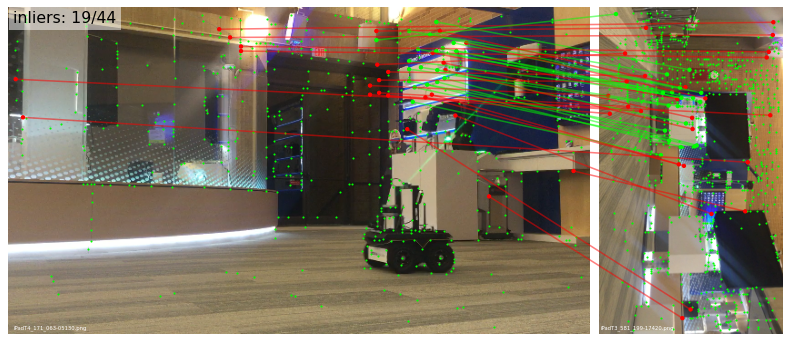

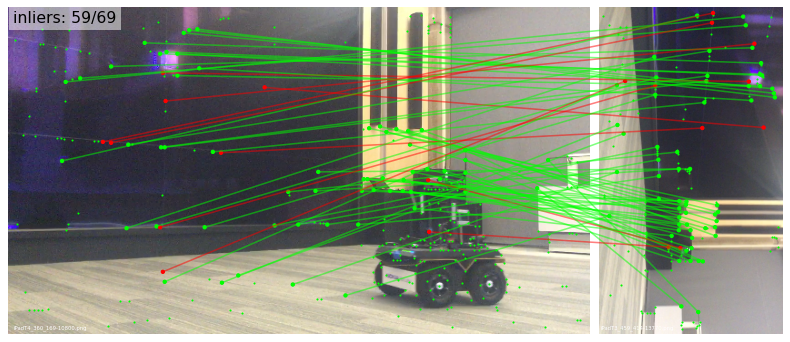

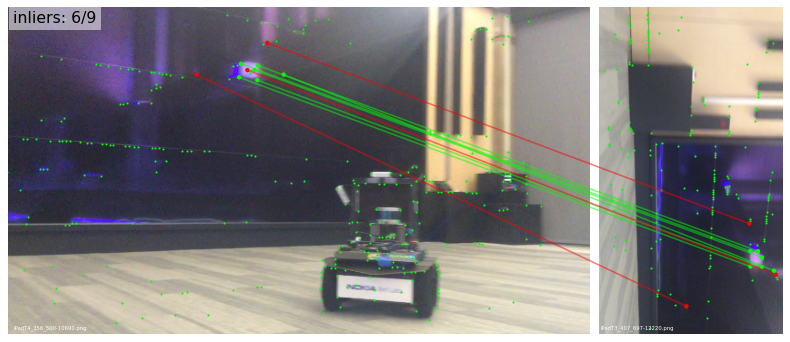

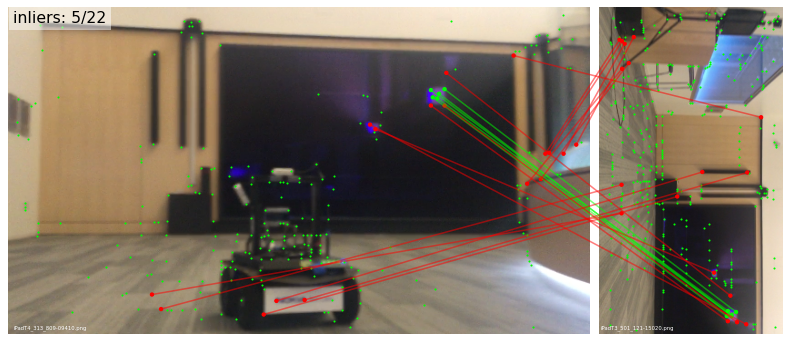

In [58]:
visualization.visualize_loc_new(
    output_path/'results_choosen.txt', path_to_images_for_map,path_to_query,local_feature_path, local_feature_path_query,  sfm_dir/"models"/"0", n=4, top_k_db=1, seed=2)